In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0507MedianFilter_3_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 11s - loss: 0.3474

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 590ms/step - loss: 0.2840
Average validation loss: 0.5555216073989868
4/4 [==============================] - 6s 607ms/step - loss: 0.2840 - val_loss: 0.5555
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 585ms/step - loss: 0.2253 - val_loss: 0.5555
Average validation loss: 0.6444391012191772
4/4 [==============================] - 8s 600ms/step - loss: 0.2253 - val_loss: 0.6000
Epoch 3/10
4/4 [==============================] - 11s 594ms/step - loss: 0.1791 - val_loss: 0.6000
Average validation loss: 0.537365734577179
4/4 [==============================] - 11s 609ms/step - loss: 0.1791 - val_loss: 0.5791
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_5.pth'.
Epoch 4/10
4/4 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 4s 554ms/step - loss: 0.0158
Average validation loss: 0.0003321953845443204
8/8 [==============================] - 5s 564ms/step - loss: 0.0158 - val_loss: 3.3220e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 9s 551ms/step - loss: 0.0165 - val_loss: 3.3220e-04
Average validation loss: 0.0002040791150648147
8/8 [==============================] - 9s 564ms/step - loss: 0.0165 - val_loss: 2.6814e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 14s 553ms/step - loss: 0.0158 - val_loss: 2.6814e-04
Average validation loss: 0.0004655255761463195
8/8 [==============================] - 14s 564ms/step - loss: 0.0158 - val_loss: 3.3393e-04
Epoch 4/10
8

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 7s 553ms/step - loss: 0.0193
Average validation loss: 0.3686660925547282
12/12 [==============================] - 7s 564ms/step - loss: 0.0193 - val_loss: 0.3687
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 13s 557ms/step - loss: 0.0185 - val_loss: 0.3687
Average validation loss: 0.24626478552818298
12/12 [==============================] - 14s 568ms/step - loss: 0.0185 - val_loss: 0.3075
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 20s 552ms/step - loss: 0.0181 - val_loss: 0.3075
Average validation loss: 0.16123648547035904
12/12 [==============================] - 20s 562ms/step - loss: 0.0181 - val_loss: 0.2587
Saved model weights to 'c

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 9s 552ms/step - loss: 0.0193
Average validation loss: 0.3834211677312851
16/16 [==============================] - 9s 563ms/step - loss: 0.0193 - val_loss: 0.3834
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 18s 555ms/step - loss: 0.0183 - val_loss: 0.3834
Average validation loss: 0.20156311988830566
16/16 [==============================] - 18s 565ms/step - loss: 0.0183 - val_loss: 0.2925
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 27s 553ms/step - loss: 0.0179 - val_loss: 0.2925
Average validation loss: 0.5475592166185379
16/16 [==============================] - 27s 565ms/step - loss: 0.0179 - val_loss: 0.3775
Epoch 4/10
16/16 [========

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 11s 549ms/step - loss: 0.0104
Average validation loss: 0.0884601578116417
20/20 [==============================] - 11s 560ms/step - loss: 0.0104 - val_loss: 0.0885
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 22s 556ms/step - loss: 0.0098 - val_loss: 0.0885
Average validation loss: 0.025952083989977837
20/20 [==============================] - 23s 566ms/step - loss: 0.0098 - val_loss: 0.0572
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 34s 553ms/step - loss: 0.0099 - val_loss: 0.0572
Average validation loss: 0.03820252891164273
20/20 [==============================] - 34s 563ms/step - loss: 0.0099 - val_loss: 0.0509
Epoch 4/10
20/20 [====

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 13s 555ms/step - loss: 0.0107
Average validation loss: 0.08413764523963134
24/24 [==============================] - 14s 565ms/step - loss: 0.0107 - val_loss: 0.0841
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 27s 557ms/step - loss: 0.0100 - val_loss: 0.0841
Average validation loss: 0.01730712673937281
24/24 [==============================] - 27s 567ms/step - loss: 0.0100 - val_loss: 0.0507
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 41s 553ms/step - loss: 0.0094 - val_loss: 0.0507
Average validation loss: 0.12351362407207489
24/24 [==============================] - 41s 563ms/step - loss: 0.0094 - val_loss: 0.0750
Epoch 4/10
24/24 [====

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 22s 555ms/step - loss: 0.0140
Average validation loss: 0.030606223829090597
40/40 [==============================] - 23s 565ms/step - loss: 0.0140 - val_loss: 0.0306
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 45s 555ms/step - loss: 0.0127 - val_loss: 0.0306
Average validation loss: 0.04126470014452934
40/40 [==============================] - 45s 565ms/step - loss: 0.0127 - val_loss: 0.0359
Epoch 3/10
40/40 [==============================] - 67s 552ms/step - loss: 0.0120 - val_loss: 0.0359
Average validation loss: 0.03946509566158056
40/40 [==============================] - 68s 562ms/step - loss: 0.0120 - val_loss: 0.0371
Epoch 4/10
40/40 [==============================] - 90s 553ms/step - loss: 0.0116 - val_loss: 0.0371
Average validation loss: 0.03960051331669092
40/40 [==================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 27s 555ms/step - loss: 0.0110
Average validation loss: 0.028869684814708307
48/48 [==============================] - 27s 565ms/step - loss: 0.0110 - val_loss: 0.0289
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 54s 554ms/step - loss: 0.0091 - val_loss: 0.0289
Average validation loss: 0.018634199718386906
48/48 [==============================] - 54s 564ms/step - loss: 0.0091 - val_loss: 0.0238
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 81s 554ms/step - loss: 0.0081 - val_loss: 0.0238
Average validation loss: 0.012870967426958183
48/48 [==============================] - 81s 564ms/step - loss: 0.0081 - val_loss: 0.0201
Saved model weights

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 31s 556ms/step - loss: 0.0114
Average validation loss: 0.01924154205646898
56/56 [==============================] - 32s 566ms/step - loss: 0.0114 - val_loss: 0.0192
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 63s 554ms/step - loss: 0.0095 - val_loss: 0.0192
Average validation loss: 0.017306973646295125
56/56 [==============================] - 63s 564ms/step - loss: 0.0095 - val_loss: 0.0183
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 95s 558ms/step - loss: 0.0082 - val_loss: 0.0183
Average validation loss: 0.015702166440730383
56/56 [==============================] - 95s 568ms/step - loss: 0.0082 - val_loss: 0.0174
Saved model weights 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 36s 556ms/step - loss: 0.0072
Average validation loss: 0.034757124925704375
64/64 [==============================] - 36s 566ms/step - loss: 0.0072 - val_loss: 0.0348
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 72s 553ms/step - loss: 0.0061 - val_loss: 0.0348
Average validation loss: 0.010680106919608079
64/64 [==============================] - 72s 564ms/step - loss: 0.0061 - val_loss: 0.0227
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 108s 554ms/step - loss: 0.0057 - val_loss: 0.0227
Average validation loss: 0.01047338671196485
64/64 [==============================] - 108s 564ms/step - loss: 0.0057 - val_loss: 0.0186
Saved model weight

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 40s 553ms/step - loss: 0.0073
Average validation loss: 0.013691173064418964
72/72 [==============================] - 40s 562ms/step - loss: 0.0073 - val_loss: 0.0137
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 80s 555ms/step - loss: 0.0060 - val_loss: 0.0137
Average validation loss: 0.0215161205528097
72/72 [==============================] - 81s 565ms/step - loss: 0.0060 - val_loss: 0.0176
Epoch 3/10
72/72 [==============================] - 121s 553ms/step - loss: 0.0054 - val_loss: 0.0176
Average validation loss: 0.01103310975142651
72/72 [==============================] - 122s 562ms/step - loss: 0.0054 - val_loss: 0.0154
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_90.pth'.
Epoch 4/10
72/72 [==

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 44s 554ms/step - loss: 0.0072
Average validation loss: 0.008107099204789848
80/80 [==============================] - 45s 564ms/step - loss: 0.0072 - val_loss: 0.0081
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 89s 553ms/step - loss: 0.0056 - val_loss: 0.0081
Average validation loss: 0.007835947163403034
80/80 [==============================] - 90s 562ms/step - loss: 0.0056 - val_loss: 0.0080
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 135s 555ms/step - loss: 0.0048 - val_loss: 0.0080
Average validation loss: 0.02012984824832529
80/80 [==============================] - 135s 565ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 4/10
80/80

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 53s 553ms/step - loss: 0.0092
Average validation loss: 0.01837310228923646
96/96 [==============================] - 54s 562ms/step - loss: 0.0092 - val_loss: 0.0184
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 107s 554ms/step - loss: 0.0072 - val_loss: 0.0184
Average validation loss: 0.020324659504694864
96/96 [==============================] - 108s 565ms/step - loss: 0.0072 - val_loss: 0.0193
Epoch 3/10
96/96 [==============================] - 162s 556ms/step - loss: 0.0060 - val_loss: 0.0193
Average validation loss: 0.015433987398864701
96/96 [==============================] - 163s 566ms/step - loss: 0.0060 - val_loss: 0.0180
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_120.pth'.
Epoch 4/10
96/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 67s 555ms/step - loss: 0.0067
Average validation loss: 0.01289773420758138
120/120 [==============================] - 68s 565ms/step - loss: 0.0067 - val_loss: 0.0129
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 135s 556ms/step - loss: 0.0053 - val_loss: 0.0129
Average validation loss: 0.007216986323085924
120/120 [==============================] - 136s 566ms/step - loss: 0.0053 - val_loss: 0.0101
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 202s 556ms/step - loss: 0.0046 - val_loss: 0.0101
Average validation loss: 0.010442967844816546
120/120 [==============================] - 204s 566ms/step - loss: 0.0046 - val_loss: 0.0102
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 80s 553ms/step - loss: 0.0061
Average validation loss: 0.015614532859318488
144/144 [==============================] - 81s 563ms/step - loss: 0.0061 - val_loss: 0.0156
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 161s 555ms/step - loss: 0.0054 - val_loss: 0.0156
Average validation loss: 0.010505174099105515
144/144 [==============================] - 163s 565ms/step - loss: 0.0054 - val_loss: 0.0131
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 242s 554ms/step - loss: 0.0047 - val_loss: 0.0131
Average validation loss: 0.008861351431632001
144/144 [==============================] - 244s 564ms/step - loss: 0.0047 - val_loss: 0.0117
S

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 88s 552ms/step - loss: 0.0041
Average validation loss: 0.0064823723743757
160/160 [==============================] - 90s 562ms/step - loss: 0.0041 - val_loss: 0.0065
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 179s 554ms/step - loss: 0.0036 - val_loss: 0.0065
Average validation loss: 0.07911654796114079
160/160 [==============================] - 180s 564ms/step - loss: 0.0036 - val_loss: 0.0428
Epoch 3/10
160/160 [==============================] - 269s 555ms/step - loss: 0.0034 - val_loss: 0.0428
Average validation loss: 0.00796057153493166
160/160 [==============================] - 271s 565ms/step - loss: 0.0034 - val_loss: 0.0312
Epoch 4/10
160/160 [==============================] - 359s 554ms/step - loss: 0.0031 - val_loss: 0.0312
Average validation loss: 0.0072824303249944934
160/1

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 111s 553ms/step - loss: 0.0076
Average validation loss: 0.019829052488785238
200/200 [==============================] - 113s 563ms/step - loss: 0.0076 - val_loss: 0.0198
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 223s 553ms/step - loss: 0.0060 - val_loss: 0.0198
Average validation loss: 0.024025122322772176
200/200 [==============================] - 225s 563ms/step - loss: 0.0060 - val_loss: 0.0219
Epoch 3/10
200/200 [==============================] - 336s 555ms/step - loss: 0.0054 - val_loss: 0.0219
Average validation loss: 0.0073443617718294265
200/200 [==============================] - 338s 564ms/step - loss: 0.0054 - val_loss: 0.0171
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_250.pth'

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:09 - loss: 4.6817e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 134s 556ms/step - loss: 0.0051
Average validation loss: 0.01394170278834584
240/240 [==============================] - 136s 566ms/step - loss: 0.0051 - val_loss: 0.0139
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 269s 554ms/step - loss: 0.0042 - val_loss: 0.0139
Average validation loss: 0.009753023311564373
240/240 [==============================] - 271s 564ms/step - loss: 0.0042 - val_loss: 0.0118
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 404s 554ms/step - loss: 0.0037 - val_loss: 0.0118
Average validation loss: 0.007721716863306938
240/240 [==============================] - 407s 564ms/step - loss: 0.0037 - val_loss: 0.0105


train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.16357792588513986, 0.14516170245962048, 0.20374194574111584, 0.10719807817082547, 0.041090100700887436, 0.02695870863969806, 0.026324501901284516, 0.012716937547529594, 0.056148682608187325, 0.01407510181769542, 0.014885898492734036, 0.009289483959029895, 0.02090557340149947, 0.13416602798470995, 0.033382464367343295, 0.016839293303835, 0.01680060637203059, 0.02218609175322622]
std_val_losses =  [0.26508039999617006, 0.19635222562445043, 0.14958213316644933, 0.11067804207625129, 0.027327202236348068, 0.024158487899250302, 0.025956056535133023, 0.005018969282529394, 0.2618941346896293, 0.019083611814916416, 0.016040961561061298, 0.009390590821771929, 0.027677778431189327, 0.3192713018846212, 0.04764276724861163, 0.0327141712973097, 0.023506986449284208, 0.029478412619085473]


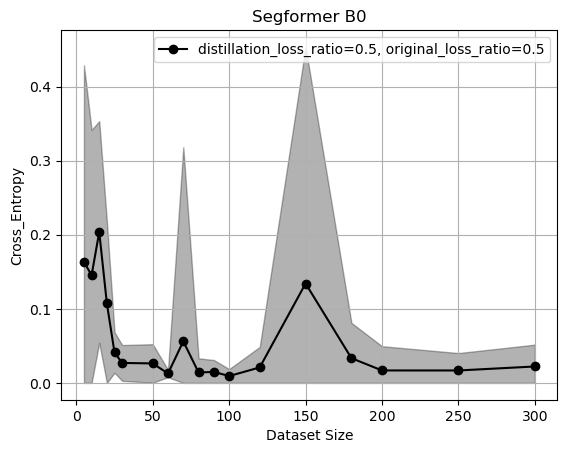

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()